In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['siim-acr-pneumothorax-segmentation', 'siimacr-pneumothorax-segmentation-data-256', 'siim-pneumothorax-augmented']


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install albumentations > /dev/null

In [4]:
!git clone https://github.com/MrGiovanni/UNetPlusPlus

Cloning into 'UNetPlusPlus'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 532 (delta 0), reused 1 (delta 0), pack-reused 529
Receiving objects: 100% (532/532), 5.81 MiB | 4.01 MiB/s, done.
Resolving deltas: 100% (265/265), done.


In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shutil, cv2
from glob import glob
from PIL import Image
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from keras import backend as K
from keras.utils.vis_utils import model_to_dot
from keras.losses import binary_crossentropy
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, Callback
from IPython.display import SVG
from UNetPlusPlus.segmentation_models import Unet

from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,OneOf,
    ToFloat, ShiftScaleRotate,GridDistortion, ElasticTransform, JpegCompression, HueSaturationValue,
    RGBShift, RandomBrightness, RandomContrast, Blur, MotionBlur, MedianBlur, GaussNoise,CenterCrop,
    IAAAdditiveGaussianNoise, GaussNoise, OpticalDistortion
)

import os
print(os.listdir("../input"))

Using TensorFlow backend.


['siim-acr-pneumothorax-segmentation', 'siimacr-pneumothorax-segmentation-data-256', 'siim-pneumothorax-augmented']


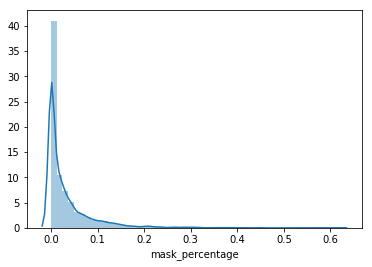

In [6]:
all_mask_fn = glob('../input/siim-pneumothorax-augmented/siim-train-test-augmented/siim-train-test-augmented/mask/*')
mask_df = pd.DataFrame()
mask_df['file_names'] = all_mask_fn
mask_df['mask_percentage'] = 0
mask_df.set_index('file_names', inplace = True)
for fn in tqdm(all_mask_fn):
    mask_df.loc[fn,'mask_percentage'] = np.array(Image.open(fn)).sum() / (512 * 512 * 255) #255 is bcz img range is 255
mask_df.reset_index(inplace = True)
sns.distplot(mask_df.mask_percentage)
mask_df['labels'] = 0
mask_df.loc[mask_df.mask_percentage > 0, 'labels'] = 1

In [7]:
all_train_fn = glob('../input/siim-pneumothorax-augmented/siim-train-test-augmented/siim-train-test-augmented/img/*')
total_samples = len(all_train_fn)
idx = np.arange(total_samples)

train_fn, val_fn = train_test_split(
    all_train_fn,
    stratify = mask_df.labels,
    test_size = 0.1,
    random_state = 10
)

print('No. of train files:', len(train_fn))
print('No. of val files:', len(val_fn))

masks_train_fn = [fn.replace('/img','/mask')[:-4]+'_mask.png' for fn in train_fn]    
masks_val_fn = [fn.replace('/img','/mask')[:-4]+'_mask.png' for fn in val_fn]

No. of train files: 3518
No. of val files: 391


In [8]:
!mkdir ./keras_im_train
train_dir = './keras_im_train'
for full_fn in train_fn:
    fn = full_fn.split('/')[-1]
    shutil.copy(full_fn,os.path.join(train_dir,fn))
    
!mkdir ./keras_mask_train
train_dir = './keras_mask_train'
for full_fn in masks_train_fn:
    fn = full_fn.split('/')[-1]
    shutil.copy(full_fn,os.path.join(train_dir,fn))
    
!mkdir ./keras_im_val
train_dir = './keras_im_val'
for full_fn in val_fn:
    fn = full_fn.split('/')[-1]
    shutil.copy(full_fn,os.path.join(train_dir,fn))
    
!mkdir ./keras_mask_val
train_dir = './keras_mask_val'
for full_fn in masks_val_fn:
    fn = full_fn.split('/')[-1]
    shutil.copy(full_fn,os.path.join(train_dir,fn))

In [9]:
class DataGenerator(keras.utils.Sequence):
    
    def __init__(self, train_im_path, train_mask_path, augmentations, batch_size, img_size, n_channels, shuffle = True):
        self.batch_size = batch_size
        self.train_im_paths = glob(train_im_path + '/*')
        
        self.train_im_path = train_im_path
        self.train_mask_path = train_mask_path

        self.img_size = img_size
        
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.augment = augmentations
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.train_im_paths) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:min((index+1)*self.batch_size,len(self.train_im_paths))]

        # Find list of IDs
        list_IDs_im = [self.train_im_paths[k] for k in indexes]

        # Generate data
        X, y = self.data_generation(list_IDs_im)

        if self.augment is None:
            return X,np.array(y) / 255
        else:
            im,mask = [], []
            for x,y in zip(X,y):
                augmented = self.augment(image=x, mask=y)
                im.append(augmented['image'])
                mask.append(augmented['mask'])
            return np.array(im), np.array(mask) / 255

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.train_im_paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def data_generation(self, list_IDs_im):
        # Initialization
        X = np.empty((len(list_IDs_im), self.img_size, self.img_size, self.n_channels))
        y = np.empty((len(list_IDs_im), self.img_size, self.img_size, 1))

        # Generate data
        for i, im_path in enumerate(list_IDs_im):
            
            im = np.array(Image.open(im_path))
            mask_path = im_path.replace(self.train_im_path, self.train_mask_path)[:-4]+'_mask.png'
            
            mask = np.array(Image.open(mask_path))
            
            if len(im.shape) == 2:
                im = np.repeat(im[...,None],3,2)

            # Resize sample
            X[i,] = cv2.resize(im,(self.img_size, self.img_size))

            # Store class
            y[i,] = cv2.resize(mask,(self.img_size, self.img_size))[..., np.newaxis]
            y[y > 0] = 255

        return np.uint8(X), np.uint8(y)

In [10]:
AUGMENTATIONS_TRAIN = Compose(
    [
        HorizontalFlip(p = 0.5),
        OneOf(
            [
                RandomContrast(),
                RandomGamma(),
                RandomBrightness(),
            ],
            p = 0.3
        ),
        OneOf(
            [
                ElasticTransform(
                    alpha = 120,
                    sigma = 120 * 0.05,
                    alpha_affine = 120 * 0.03
                ),
                GridDistortion(),
                OpticalDistortion(
                    distort_limit = 2,
                    shift_limit = 0.5
                ),
            ],
            p = 0.3
        ),
        ToFloat(max_value = 1)
    ],
    p = 1
)

In [11]:
AUGMENTATIONS_TEST = Compose(
    [
        ToFloat(max_value = 1)
    ],
    p = 1
)

In [12]:
TRAIN_IMAGE_PATH = './keras_im_train'
TRAIN_MASK_PATH = './keras_mask_train'
VAL_IMAGE_PATH = './keras_im_val'
VAL_MASK_PATH = './keras_mask_val'
IMAGE_SIZE = 512
IMAGE_CHANNELS = 3
BATCH_SIZE = 8
EPOCHS = 4

Text(0.5, 0.98, 'Chest X-rays, Red: Pneumothorax.')

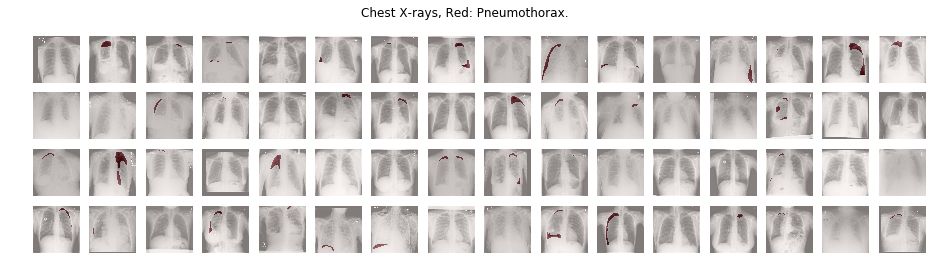

In [13]:
a = DataGenerator(
    TRAIN_IMAGE_PATH,
    TRAIN_MASK_PATH,
    None,
    batch_size = 64,
    img_size = 512,
    n_channels = 3,
    shuffle = False
)

images, masks = a.__getitem__(0)
max_images = 64
grid_width = 16
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize = (grid_width, grid_height))

for i, (im, mask) in enumerate(zip(images, masks)):
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(im.squeeze(), cmap = "bone")
    ax.imshow(mask.squeeze(), alpha = 0.5, cmap = "Reds")    
    ax.axis('off')
plt.suptitle("Chest X-rays, Red: Pneumothorax.")

In [14]:
def get_iou_vector(A, B):
    # Numpy version    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric

In [15]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

In [16]:
def iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred > 0.5], tf.float64)

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

In [17]:
class SnapshotCallbackBuilder:
    def __init__(self, nb_epochs, nb_snapshots, init_lr=0.1):
        self.T = nb_epochs
        self.M = nb_snapshots
        self.alpha_zero = init_lr

    def get_callbacks(self, model_prefix='Model'):

        callback_list = [
            ModelCheckpoint(
                "./keras.model",
                monitor = 'val_iou_metric',
                mode = 'max',
                save_best_only = True,
                verbose = 1
            ),
            swa,
            LearningRateScheduler(
                schedule = self._cosine_anneal_schedule)
        ]

        return callback_list

    def _cosine_anneal_schedule(self, t):
        cos_inner = np.pi * (t % (self.T // self.M))  # t - 1 is used when t has 1-based indexing.
        cos_inner /= self.T // self.M
        cos_out = np.cos(cos_inner) + 1
        return float(self.alpha_zero / 2 * cos_out)

In [18]:
class SWA(Callback):
    
    def __init__(self, filepath, swa_epoch):
        super(SWA, self).__init__()
        self.filepath = filepath
        self.swa_epoch = swa_epoch 
    
    def on_train_begin(self, logs=None):
        self.nb_epoch = self.params['epochs']
        print('Stochastic weight averaging selected for last {} epochs.'
              .format(self.nb_epoch - self.swa_epoch))
        
    def on_epoch_end(self, epoch, logs=None):
        if epoch == self.swa_epoch:
            self.swa_weights = self.model.get_weights()
        elif epoch > self.swa_epoch:    
            for i in range(len(self.swa_weights)):
                self.swa_weights[i] = (self.swa_weights[i] * 
                    (epoch - self.swa_epoch) + self.model.get_weights()[i])/((epoch - self.swa_epoch)  + 1)  
        else:
            pass
        
    def on_train_end(self, logs=None):
        self.model.set_weights(self.swa_weights)
        print('Final model parameters set to stochastic weight average.')
        self.model.save_weights(self.filepath)
        print('Final stochastic averaged weights saved to file.')

In [19]:
model = Unet(
    backbone_name = 'resnet50',
    input_shape = (512, 512, 3),
    decoder_block_type = 'transpose',
    activation = 'softmax'
)

94593024/94592056 [==============================] - 3s 0us/step


In [20]:
model.compile(loss = bce_dice_loss, optimizer = 'adam', metrics = [iou_metric])

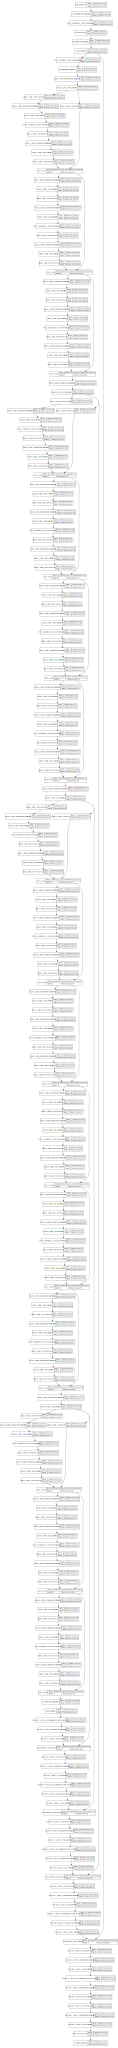

In [21]:
SVG(model_to_dot(model, show_shapes = True, show_layer_names = True).create(prog = 'dot', format = 'svg'))

In [22]:
snapshot = SnapshotCallbackBuilder(nb_epochs = EPOCHS, nb_snapshots = 1, init_lr = 1e-3)
swa = SWA('./keras_swa.model', EPOCHS - 3)

In [23]:
training_generator = DataGenerator(
    TRAIN_IMAGE_PATH,
    TRAIN_MASK_PATH,
    AUGMENTATIONS_TRAIN,
    batch_size = BATCH_SIZE,
    img_size = IMAGE_SIZE,
    n_channels = IMAGE_CHANNELS,
    shuffle = False
)

validation_generator = DataGenerator(
    VAL_IMAGE_PATH,
    VAL_MASK_PATH,
    AUGMENTATIONS_TEST,
    batch_size = BATCH_SIZE,
    img_size = IMAGE_SIZE,
    n_channels = IMAGE_CHANNELS,
    shuffle = False
)

In [24]:
history = model.fit_generator(
    generator = training_generator,
    validation_data = validation_generator,
    use_multiprocessing = False,
    epochs = EPOCHS,
    verbose = 1,
    callbacks = snapshot.get_callbacks()
)

Stochastic weight averaging selected for last 3 epochs.
Epoch 1/4
440/440 [==============================] - 341s 775ms/step - loss: 16.7862 - iou_metric: 0.0000e+00 - val_loss: 16.7836 - val_iou_metric: 0.0000e+00

Epoch 00001: val_iou_metric improved from -inf to 0.00000, saving model to ./keras.model
Epoch 2/4
440/440 [==============================] - 309s 703ms/step - loss: 16.7864 - iou_metric: 0.0000e+00 - val_loss: 16.7836 - val_iou_metric: 0.0000e+00

Epoch 00002: val_iou_metric did not improve from 0.00000
Epoch 3/4
440/440 [==============================] - 304s 691ms/step - loss: 16.7857 - iou_metric: 0.0000e+00 - val_loss: 16.7836 - val_iou_metric: 0.0000e+00

Epoch 00003: val_iou_metric did not improve from 0.00000
Epoch 4/4
440/440 [==============================] - 314s 714ms/step - loss: 16.7877 - iou_metric: 0.0000e+00 - val_loss: 16.7836 - val_iou_metric: 0.0000e+00

Epoch 00004: val_iou_metric did not improve from 0.00000
Final model parameters set to stochastic wei

Text(0.5, 1.0, 'model loss')

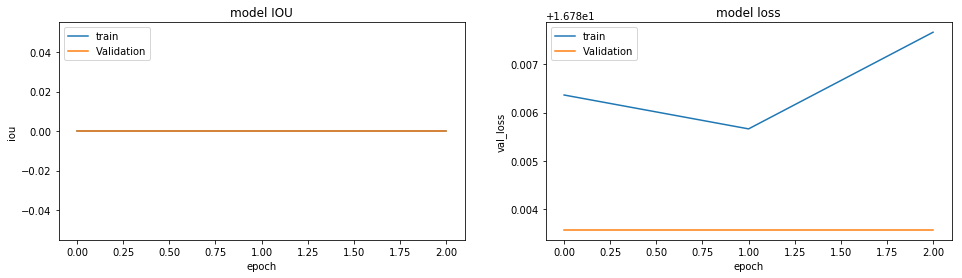

In [25]:
plt.figure(figsize = (16, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['iou_metric'][1:])
plt.plot(history.history['val_iou_metric'][1:])
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')

plt.title('model IOU')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc = 'upper left')
plt.title('model loss')
#gc.collect()

In [26]:
def predict_result(model,validation_generator,img_size): 
    # TBD predict both orginal and reflect x
    preds_test1 = model.predict_generator(validation_generator).reshape(-1, img_size, img_size)
    return preds_test1

In [27]:
validation_generator = DataGenerator(train_im_path = VAL_IMAGE_PATH ,
                                     train_mask_path=VAL_MASK_PATH,augmentations=AUGMENTATIONS_TEST,
                                     img_size=IMAGE_SIZE,shuffle=False, batch_size = 16, n_channels = 3)

AUGMENTATIONS_TEST_FLIPPED = Compose([
    HorizontalFlip(),
    ToFloat(max_value=1)
],p=1)

validation_generator_flipped = DataGenerator(train_im_path = VAL_IMAGE_PATH ,
                                     train_mask_path=VAL_MASK_PATH,augmentations=AUGMENTATIONS_TEST_FLIPPED,
                                     img_size=IMAGE_SIZE,shuffle=False, batch_size = 16, n_channels = 3)

preds_valid_orig = predict_result(model,validation_generator,IMAGE_SIZE)
preds_valid_flipped = predict_result(model,validation_generator_flipped,IMAGE_SIZE)
preds_valid_flipped = np.array([np.fliplr(x) for x in preds_valid_flipped])
preds_valid = 0.5*preds_valid_orig + 0.5*preds_valid_flipped

In [28]:
valid_fn = glob('./keras_mask_val/*')
y_valid_ori = np.array([cv2.resize(np.array(Image.open(fn)),(IMAGE_SIZE,IMAGE_SIZE)) for fn in valid_fn])
assert y_valid_ori.shape == preds_valid.shape

Text(0.5, 0.98, 'Green:Prediction , Red: Pneumothorax.')

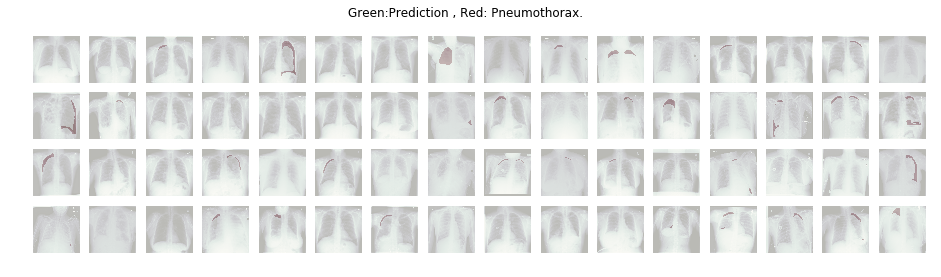

In [29]:
threshold_best = 0.5
max_images = 64
grid_width = 16
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))

validation_generator = DataGenerator(train_im_path = VAL_IMAGE_PATH ,
                                     train_mask_path=VAL_MASK_PATH,augmentations=AUGMENTATIONS_TEST,
                                     img_size=IMAGE_SIZE,batch_size=64,shuffle=False, n_channels = 3)

images,masks = validation_generator.__getitem__(0)
for i,(im, mask) in enumerate(zip(images,masks)):
    pred = preds_valid[i]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(im[...,0], cmap="bone")
    ax.imshow(mask.squeeze(), alpha=0.5, cmap="Reds")    
    ax.imshow(np.array(np.round(pred > threshold_best), dtype=np.float32), alpha=0.5, cmap="Greens")
    ax.axis('off')
plt.suptitle("Green:Prediction , Red: Pneumothorax.")

In [30]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

valid_fn = glob('./keras_mask_val/*')
y_valid_ori = np.array([cv2.resize(np.array(Image.open(fn)),(IMAGE_SIZE,IMAGE_SIZE)) for fn in valid_fn])
#assert y_valid_ori.shape == preds_valid.shape

In [31]:
## Scoring for last model
from tqdm import tqdm_notebook

thresholds = np.linspace(0.2, 0.9, 31)
ious = np.array([iou_metric_batch(y_valid_ori, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds)])

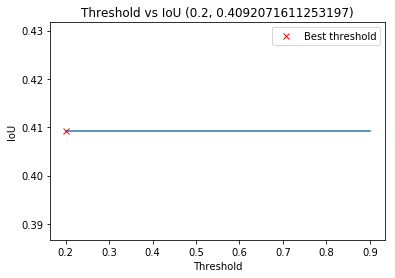

In [32]:
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [33]:
test_fn = glob('../input/siimacr-pneumothorax-segmentation-data-256/test/*')
x_test = [cv2.resize(np.array(Image.open(fn)),(IMAGE_SIZE,IMAGE_SIZE)) for fn in test_fn]
x_test = np.array(x_test)
x_test = np.array([np.repeat(im[...,None],3,2) for im in x_test])
print(x_test.shape)
preds_test_orig = model.predict(x_test,batch_size=BATCH_SIZE)

x_test = np.array([np.fliplr(x) for x in x_test])
preds_test_flipped = model.predict(x_test,batch_size=BATCH_SIZE)
preds_test_flipped = np.array([np.fliplr(x) for x in preds_test_flipped])

preds_test = 0.5*preds_test_orig + 0.5*preds_test_flipped

(1377, 512, 512, 3)


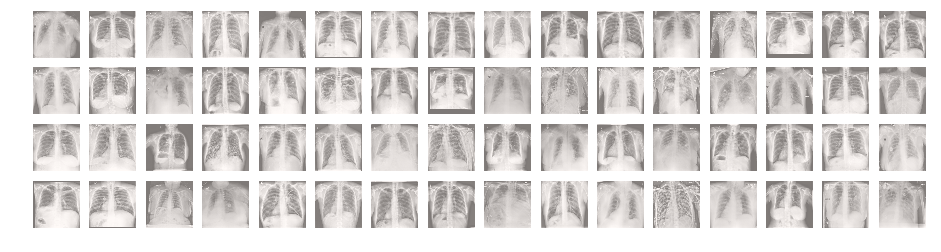

In [34]:
max_images = 64
grid_width = 16
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
# for i, idx in enumerate(index_val[:max_images]):
for i, idx in enumerate(test_fn[:max_images]):
    img = x_test[i]
    pred = preds_test[i].squeeze()
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(np.array(np.round(pred > threshold_best).T, dtype=np.float32), alpha=0.5, cmap="Reds")
    ax.axis('off')

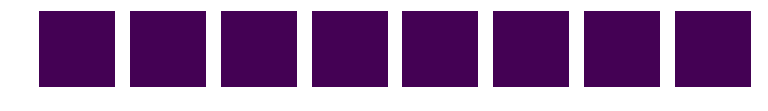

In [35]:
import sys
sys.path.insert(0, '../input/siim-acr-pneumothorax-segmentation')

from mask_functions import rle2mask,mask2rle
import pdb

# Generate rle encodings (images are first converted to the original size)
rles = []
i,max_img = 1,10
plt.figure(figsize=(16,4))
for p in tqdm_notebook(preds_test):
    p = p.squeeze()
    im = cv2.resize(p,(1024,1024))
    im = im > threshold_best
#     zero out the smaller regions.
    if im.sum()<1024*2:
        im[:] = 0
    im = (im.T*255).astype(np.uint8)  
    rles.append(mask2rle(im, 1024, 1024))
    i += 1
    if i<max_img:
        plt.subplot(1,max_img,i)
        plt.imshow(im)
        plt.axis('off')

In [36]:
ids = [o.split('/')[-1][:-4] for o in test_fn]
sub_df = pd.DataFrame({'ImageId': ids, 'EncodedPixels': rles})
sub_df.loc[sub_df.EncodedPixels=='', 'EncodedPixels'] = '-1'
sub_df.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6535.151787519...,-1
1,1.2.276.0.7230010.3.1.4.8323329.6031.151787519...,-1
2,1.2.276.0.7230010.3.1.4.8323329.6857.151787520...,-1
3,1.2.276.0.7230010.3.1.4.8323329.5945.151787519...,-1
4,1.2.276.0.7230010.3.1.4.8323329.6916.151787520...,-1


In [37]:
sub_df.to_csv('submission.csv', index=False)

In [38]:
shutil.rmtree('./keras_im_train', ignore_errors=False, onerror=None)
shutil.rmtree('./keras_im_val', ignore_errors=False, onerror=None)
shutil.rmtree('./keras_mask_train', ignore_errors=False, onerror=None)
shutil.rmtree('./keras_mask_val', ignore_errors=False, onerror=None)
shutil.rmtree('./UNetPlusPlus', ignore_errors=False, onerror=None)

In [39]:
! rm -r './keras_im_train'

rm: cannot remove './keras_im_train': No such file or directory


In [40]:
! rm -r './keras_im_val'

rm: cannot remove './keras_im_val': No such file or directory


In [41]:
! rm -r './keras_mask_train'

rm: cannot remove './keras_mask_train': No such file or directory


In [42]:
! rm -r './keras_mask_val'

rm: cannot remove './keras_mask_val': No such file or directory


In [43]:
! rm -r './UNetPlusPlus'

rm: cannot remove './UNetPlusPlus': No such file or directory
